https://github.com/rbeucher/UW_Huismans_like/blob/master/Huismans_like_model.ipynb

In [1]:
import underworld as uw
from underworld import function as fn
from underworld.scaling import units as u
from underworld.scaling import dimensionalise
from underworld.scaling import non_dimensionalise as nd
import underworld.visualisation as vis
#from lithopress import Lithostatic_pressure    

import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [4]:
checkpoint_restart = False
freesurf_bc = False

if freesurf_bc:
    outputfile = "output_uw_Huismans_like_rs_stickair_fs/"
else:
    outputfile = "output_uw_Huismans_like_rs_stickair_noairbalance_shortbox/"
outputPath = os.path.join(os.path.abspath("."),outputfile) 
    
if uw.mpi.rank==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.mpi.barrier()

velocity = 1.0 * u.centimeter/u.year
K_gravity = 10. * u.meter / u.second**2

KL = 100 * u.kilometer
K_viscosity = 1e18 * u.pascal * u.second
K_density   = 3300 * u.kilogram / u.meter**3

# build reference units
#KM = K_density * KL **3
#Kt = KM / ( KL * K_viscosity )

Kt = KL /velocity
bodyforce = K_density  * K_gravity 
KM = bodyforce * KL**2 * Kt**2

scaling_coefficients = uw.scaling.get_coefficients()
scaling_coefficients["[length]"]      = KL.to_base_units()
#scaling_coefficients["[temperature]"] = Kt_degrees.to_base_units()
scaling_coefficients["[time]"]        = Kt.to_base_units()
scaling_coefficients["[mass]"]        = KM.to_base_units()

gravity = nd(K_gravity)
Dy = nd(-380* u.kilometer)
Lx = nd(200* u.kilometer)
Hy = nd(20* u.kilometer)

xmin,xmax = -Lx,Lx
ymin,ymax = Dy,Hy
resolution = (80,80)
mesh = uw.mesh.FeMesh_Cartesian( elementType = 'Q1/dQ0', 
                                 elementRes  = resolution, 
                                 minCoord    = [xmin,ymin], 
                                 maxCoord    = [xmax,ymax],
                                 periodic    = [False, False] )
velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
tractionField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )

# set initial conditions (and boundary values)
if checkpoint_restart == False:
    velocityField.data[:] = [0.,0.]
    pressureField.data[:] = 0.
    tractionField.data[:] = [0.,0.]
else:
    velocityField.load(outputPath_restart+'velocityField.'+ str(step).zfill(5) +'.h5')
    pressureField.load(outputPath_restart+'pressureField.'+ str(step).zfill(5) +'.h5')
    #tractionField.load(outputPath_restart+'tractionField.'+ str(step).zfill(5) +'.h5')

In [5]:
H_air = np.abs(Hy)
D_crust = nd(-40 * u.kilometer)
D_ml = nd(-160 * u.kilometer)

coord = fn.input()
#interface0 = (fn.math.sin(coord[0]*(2.*np.pi)/(xmax-xmin)/2.) + nd(0.*u.kilometer))*H_air/2.
interface0 = fn.misc.constant(nd(0.*u.meter)) 
interface1 = fn.misc.constant(D_crust)  
interface2 = fn.misc.constant(D_ml)

In [6]:
particlesPerCell  = 20

swarm = uw.swarm.Swarm( mesh=mesh,particleEscape=True)
materialVariable = swarm.add_variable( dataType="int", count=1)
viscosityField = swarm.add_variable(dataType="double", count=1)

# # if reloading from checkpoint
if checkpoint_restart == True:
    swarm.load(outputPath_restart+'swarm.'         + str(step).zfill(5) +'.h5')
    materialIndex.load( outputPath_restart+'materialIndex.' + str(step).zfill(5) +'.h5')
    viscosityField.load( outputPath_restart+'viscosityField.' + str(step).zfill(5) +'.h5')
else:
    swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=particlesPerCell )
    #swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=1)
    swarm.populate_using_layout( layout=swarmLayout )
    
    viscosityField.data[:] = [0.]
    
    air_index = 1
    crust_index = 2
    ml_index = 3
    ma_index = 4 
    condition_shape = [(coord[1]>interface0,air_index),
                       (coord[1]>interface1,crust_index),
                       (coord[1]>interface2,ml_index),
                        (True, ma_index)]  
    materialVariable.data[:] = fn.branching.conditional(condition_shape).evaluate(swarm)    
pop_control = uw.swarm.PopulationControl(swarm,aggressive=True,splitThreshold=0.15, maxDeletions=2,maxSplits=10,
                                                particlesPerCell=20)

In [7]:
# Density
air_rho = nd(1. * u.kilogram / u.meter**3)
crust_rho = nd(2700. * u.kilogram / u.meter**3)
ml_rho = nd(3300. * u.kilogram / u.meter**3)
ma_rho = nd(3300. * u.kilogram / u.meter**3)

densityMap  = {air_index:0.,crust_index:crust_rho, ml_index:ml_rho,ma_index:ma_rho}
densityFn   = fn.branching.map(fn_key= materialVariable, mapping = densityMap)

densityVar =  uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1 )
projectorDensity = uw.utils.MeshVariable_Projection(densityVar, densityFn, type=0)
projectorDensity.solve()

# Viscosity
air_visc = nd(1e18 * u.pascal * u.second)
crust_visc =  nd(1e22 * u.pascal * u.second)
ml_visc =  nd(1e20 * u.pascal * u.second)
ma_visc =  nd(1e20 * u.pascal * u.second)

viscMap  = {air_index:air_visc,crust_index:crust_visc, ml_index:ml_visc,ma_index:ma_visc}
viscFn   = fn.branching.map( fn_key= materialVariable, mapping = viscMap)

_projviscosityField  = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1 )
_viscosityFieldProjector = uw.utils.MeshVariable_Projection(_projviscosityField,viscosityField,
                                                     voronoi_swarm=swarm,type=0)
viscosityField.data[...] = viscFn.evaluate(swarm)
_viscosityFieldProjector.solve()

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant( strainRateFn )

forceFn = densityFn * (0.0,-gravity)
#forceFn = (0.0,0.0)

In [12]:
minbox = (xmin,ymin)
maxbox = (xmax,ymax) 
figsize = (800,800)


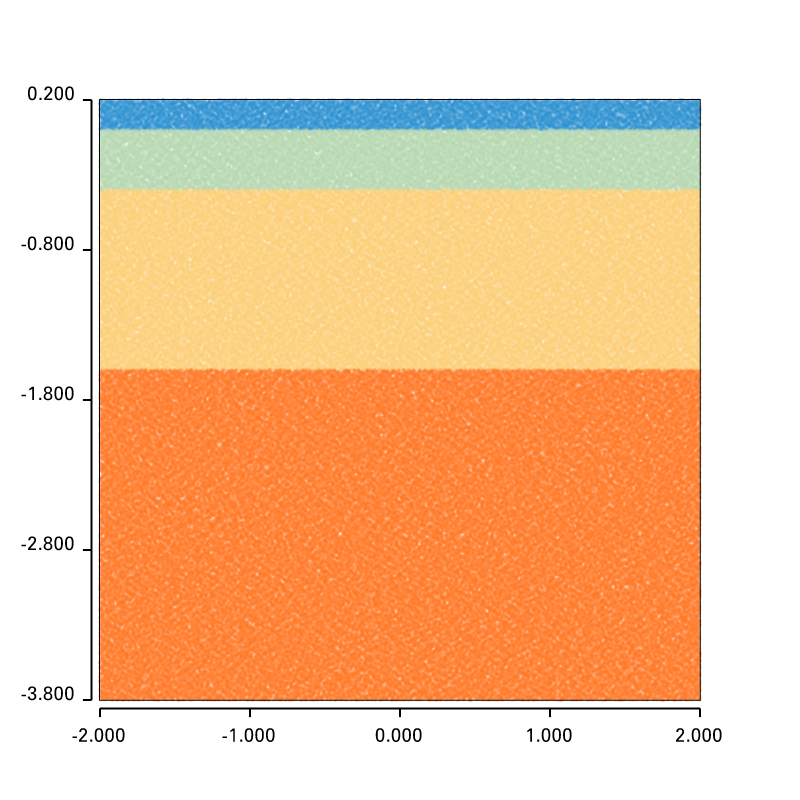

In [13]:
fig0 = vis.Figure( figsize=figsize,quality=3,clipmap=False, xmin=minbox[0], xmax=maxbox[0], ymin=minbox[1], ymax=maxbox[1],
                        boundingBox=(minbox,maxbox),margin = 100, rulers = True, rulerticks=5)
fig0.Points(swarm,materialVariable,pointSize=5,discrete=False,opacity=0.5,colourBar = False)#colours="jet" ,
fig0.VectorArrows(mesh,velocityField) #,scaling=2e-1) 
fig0.save(outputPath+'Model_steup.png') 
fig0.show()

In [14]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
botWalls   = mesh.specialSets["MinJ_VertexSet"]
topWalls   = mesh.specialSets["MaxJ_VertexSet"]
leftWalls  = mesh.specialSets["MinI_VertexSet"]  
rightWalls = mesh.specialSets["MaxI_VertexSet"]

In [15]:
#  Boundary conditions

# balance the velocity of the rock part 
v_interface1 = nd(-80* u.kilometer)
velocity1 = 7.5 *u.cm/u.year
v_ratio = 4/15 # 80/(380-80)
for index in leftWalls:
    if mesh.data[index][1] > 0.:
        velocityField.data[index] = [nd(velocity1),0.]
    elif mesh.data[index][1] > v_interface1:
        velocityField.data[index] = [nd(velocity1),0.]
    #elif mesh.data[index][1] >= v_interface2:
    #    velocityField.data[index] = [0.,0.]
    else:
        velocityField.data[index] = [nd(-velocity1)*v_ratio,0.]
for index in rightWalls:
    if mesh.data[index][1] > 0.:
        velocityField.data[index] = [nd(-velocity1),0.]
    elif mesh.data[index][1] > v_interface1:
        velocityField.data[index] = [nd(-velocity1),0.]
    #elif mesh.data[index][1] >= v_interface2:
    #    velocityField.data[index] = [0.,0.]
    else:
        velocityField.data[index] = [nd(velocity1)*v_ratio,0.]
        
Dir_BC = uw.conditions.DirichletCondition( variable = velocityField, 
                                            indexSetsPerDof = (iWalls,iWalls+botWalls))

In [16]:
index_rock_leftwalls = np.where((mesh.data[leftWalls])[:,1]<0.)
dimensionalise(np.mean(velocityField[0].evaluate(mesh.data[index_rock_leftwalls])),u.centimeter/u.year)

-0.025974025974025913 <Unit('centimeter / year')>


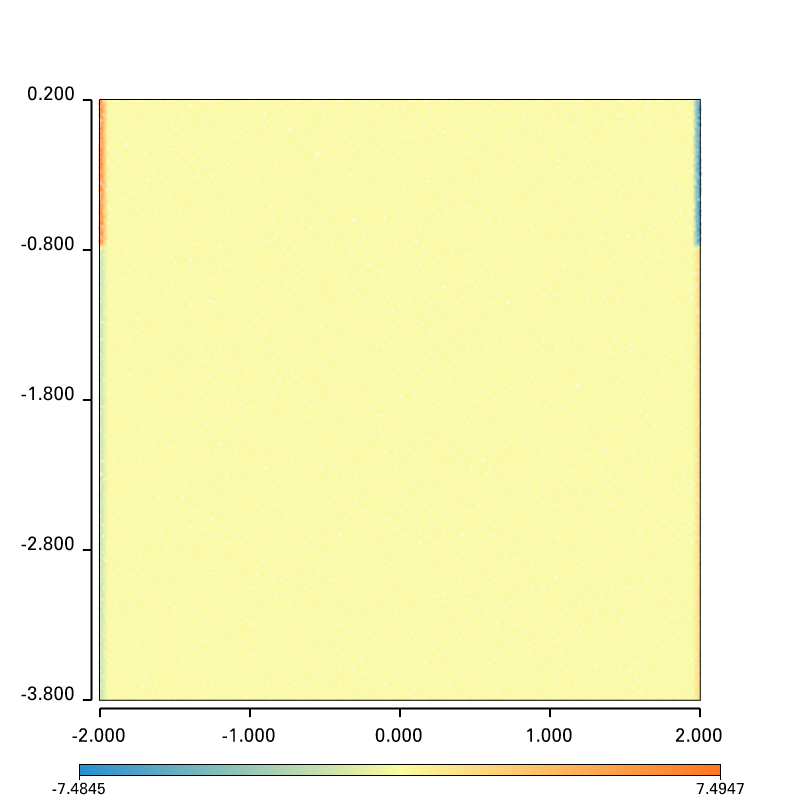

In [17]:
fig1 = vis.Figure( figsize=figsize,quality=3,clipmap=False, xmin=minbox[0], xmax=maxbox[0], ymin=minbox[1], ymax=maxbox[1],
                        boundingBox=(minbox,maxbox),margin = 100, rulers = True, rulerticks=5)
fig1.Points(swarm,velocityField[0],pointSize=5,discrete=False,opacity=0.5,colourBar = True)#colours="jet" ,
#fig1.VectorArrows(mesh,velocityField) #,scaling=2e-1) 
fig1.save(outputPath+'V_bc.png') 
fig1.show()

In [18]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = Dir_BC,
                               fn_viscosity  = viscFn, 
                               fn_bodyforce  = forceFn) # )
                               #fn_one_on_lambda = lambdaFn) 
solver = uw.systems.Solver(stokes)
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

# surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=topWalls)
# surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=topWalls)
# def pressure_calibrate():
#     (area,) = surfaceArea.evaluate()
#     (p0,) = surfacePressureIntegral.evaluate()
#     offset = p0/area
#     pressureField.data[:] -= offset
# def traction_calibrate():
#     (area,) = surfaceArea.evaluate()
#     (p0,) = surfacePressureIntegral.evaluate()
#     offset = p0/area
#     return offset,p0

In [19]:
solver.set_inner_method("mumps")
#solver.set_inner_method("mg")
#solver.set_penalty(1e6)

In [20]:
from scipy.interpolate import interp1d
import underworld as uw
from mpi4py import MPI as _MPI

comm = _MPI.COMM_WORLD
rank = comm.rank
size = comm.size

class FreeSurfaceProcessor(object):
    """FreeSurfaceProcessor"""

    def __init__(self):
        """Create a Freesurface processor


        """

        # Create the tools
        self.TField = mesh.add_variable(nodeDofCount=1)
        self.TField.data[:, 0] = mesh.data[:, 1]

        self.top = mesh.specialSets["Top_VertexSet"]
        self.bottom = mesh.specialSets["Bottom_VertexSet"]

        # Create boundary condition
        self._conditions = uw.conditions.DirichletCondition(
            variable=self.TField,
            indexSetsPerDof=(self.top + self.bottom,))

        # Create Eq System
        self._system = uw.systems.SteadyStateHeat(
            temperatureField=self.TField,
            fn_diffusivity=1.0,
            conditions=self._conditions)

        self._solver = uw.systems.Solver(self._system)

    def _solve_sle(self):
        self._solver.solve()

    def _advect_surface(self, dt):

        if self.top:
            # Extract top surface
            x =  mesh.data[self.top.data][:, 0]
            y =  mesh.data[self.top.data][:, 1]

            # Extract velocities from top
            vx = velocityField.data[self.top.data][:, 0]
            vy = velocityField.data[self.top.data][:, 1]

            # Advect top surface
            x2 = x + vx * nd(dt)
            y2 = y + vy * nd(dt)

            # Spline top surface
            f = interp1d(x2, y2, kind='cubic', fill_value='extrapolate')

            self.TField.data[self.top.data, 0] = f(x)
        comm.Barrier()
        self.TField.syncronise()

    def _update_mesh(self):

        with  mesh.deform_mesh():
            # Last dimension is the vertical dimension
             mesh.data[:, -1] = self.TField.data[:, 0]

    def solve(self, dtime):
        """ Advect free surface through dt and update the mesh """

        # First we advect the surface
        self._advect_surface(dtime)
        # Then we solve the system of linear equation
        self._solve_sle()
        # Finally we update the mesh
        self._update_mesh()

In [21]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=topWalls)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=topWalls)


def pressure_calibrate():
    
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    pressureField.data[:] -= offset

In [ ]:
# record output
outfile = open(outputPath+'buildMount.txt', 'w+')
string = "steps, timestep"
if uw.mpi.rank==0:
    print(string)
    outfile.write( string+"\n")

# initialise loop
dt    = -1.
model_end_step  = 50
steps = 0


while steps<model_end_step:
    # Get solution
    #solver.solve( nonLinearIterate=True,  nonLinearTolerance=1e-5, nonLinearMaxIterations=25)
    solver.solve( nonLinearIterate=True,  nonLinearTolerance=1e-5, nonLinearMaxIterations=25,callback_post_solve = pressure_calibrate)
    # get time step first time around
    if dt < 0:
        dt = 0.5*advector.get_max_dt()
        #dt = nd(2*u.kiloyear)
    # Advect particles   
    advector.integrate(dt)  

    string = "{}, {:.3e}".format(steps,dimensionalise(dt, u.kiloyear))
    if uw.mpi.rank == 0:
        print(string)
        outfile.write(string+"\n")
    
        
    if freesurf_bc:
        freesuface =  FreeSurfaceProcessor()
        freesuface.solve(dt)

    # population control
    pop_control.repopulate()
    fig0.save(outputPath+"Uplift-"+str(steps)+".png")

# #     offset,p0 = traction_calibrate()
#     Tpressure = cal_lithop(mesh,densityFn,gravity)
#     for index,coord in enumerate (botWalls.data):
#         tractionField.data[coord]= (0,Tpressure[0,index])
        
# #     Tpressure = cal_lithop(mesh,densityFn,gravity)
# #     tractionField.data[:,1] = Tpressure.flatten() 

#     fig, ax = plt.subplots(1, 1, figsize=(8,6))
#     ax.set_xlabel('X coordinate (km)')
#     ax.set_ylabel('Bottom pressure (megapascal)')
#     ax.plot(xcoord,dimensionalise(Tpressure[0,:], u.megapascal),'o', color = 'blue',label = 'mesh nodes evaluate')
#     plt.legend()
#     plt.savefig(outputPath+"Evaluated base pressure"+str(steps)+".png")
    
    steps += 1
outfile.close()

steps, timestep
0, 1.645e+01 kiloyear


In [ ]:
fig0.show()

In [ ]:
stress = strainRate_2ndInvariant*viscosityField

In [ ]:
fig2 = vis.Figure( figsize=figsize,quality=3,clipmap=False, xmin=minbox[0], xmax=maxbox[0], ymin=minbox[1], ymax=maxbox[1],
                        boundingBox=(minbox,maxbox),margin = 100, rulers = True, rulerticks=5)
fig2.Points(swarm,stress,pointSize=5,discrete=False,opacity=0.5,colourBar = True)#colours="jet" ,
#fig2.VectorArrows(mesh,velocityField) #,scaling=2e-1) 
fig2.save(outputPath+'stress.png') 
fig2.show()

In [ ]:
stress1 = dimensionalise(stress.evaluate(mesh),u.pascal)

In [ ]:
stress1.max()